In [1]:
import pickle
import os
import lc_model as model
import matplotlib.pyplot as plt
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import parallel_simulation as sim
from create_dataset import SimulationData as simData

In [2]:
num_simulations = 2000
batch_size = 50
num_batches = num_simulations // batch_size + (1 if num_simulations % batch_size != 0 else 0)
num_workers = 8

all_data = sim.Simulation.load_all_data(num_batches, num_workers)

Batch 5 for worker 0 not found.
Batch 6 for worker 0 not found.
Batch 7 for worker 0 not found.
Batch 8 for worker 0 not found.
Batch 9 for worker 0 not found.
Batch 10 for worker 0 not found.
Batch 11 for worker 0 not found.
Batch 12 for worker 0 not found.
Batch 13 for worker 0 not found.
Batch 14 for worker 0 not found.
Batch 15 for worker 0 not found.
Batch 16 for worker 0 not found.
Batch 17 for worker 0 not found.
Batch 18 for worker 0 not found.
Batch 19 for worker 0 not found.
Batch 20 for worker 0 not found.
Batch 21 for worker 0 not found.
Batch 22 for worker 0 not found.
Batch 23 for worker 0 not found.
Batch 24 for worker 0 not found.
Batch 25 for worker 0 not found.
Batch 26 for worker 0 not found.
Batch 27 for worker 0 not found.
Batch 28 for worker 0 not found.
Batch 29 for worker 0 not found.
Batch 30 for worker 0 not found.
Batch 31 for worker 0 not found.
Batch 32 for worker 0 not found.
Batch 33 for worker 0 not found.
Batch 34 for worker 0 not found.
Batch 35 for wo

# Format data for training - All data

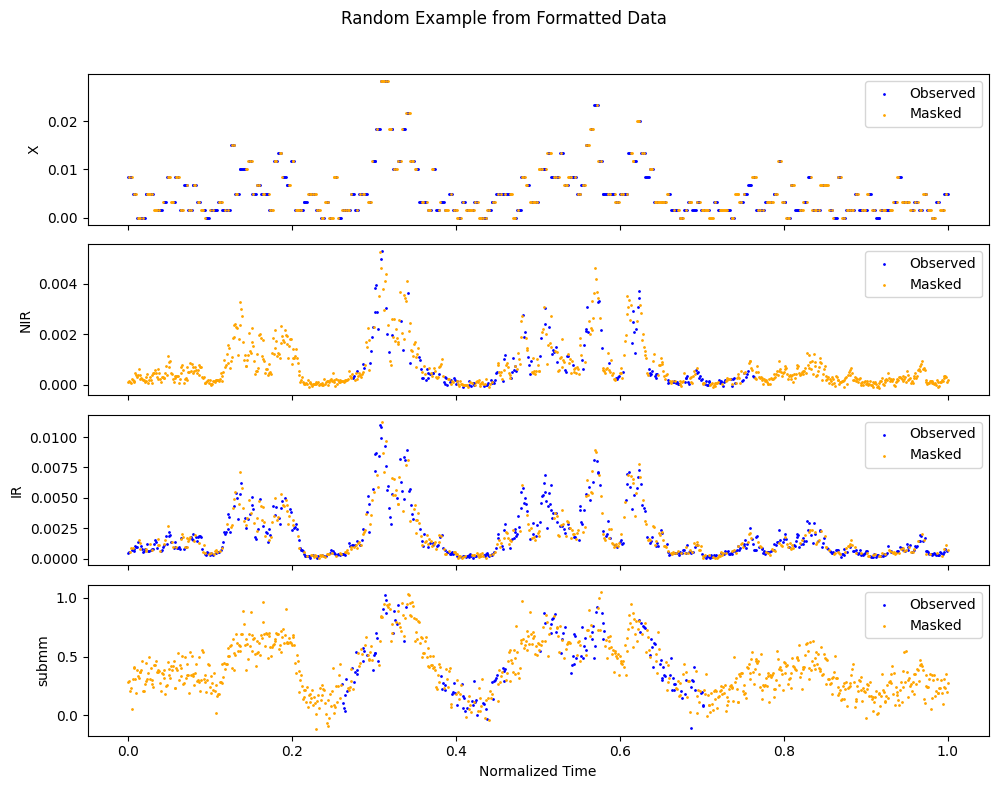

In [3]:
filename = 'sgra.npz'
keys = ['X', 'NIR', 'IR', 'submm']

simdata = simData(all_data)

simdata.mask_data(noise=0.2)

simdata.create_tripletformer_data(filename, keys=keys)

# Usage
simdata.plot_random_example(filename, keys=keys)

# Format data for training - No X-ray

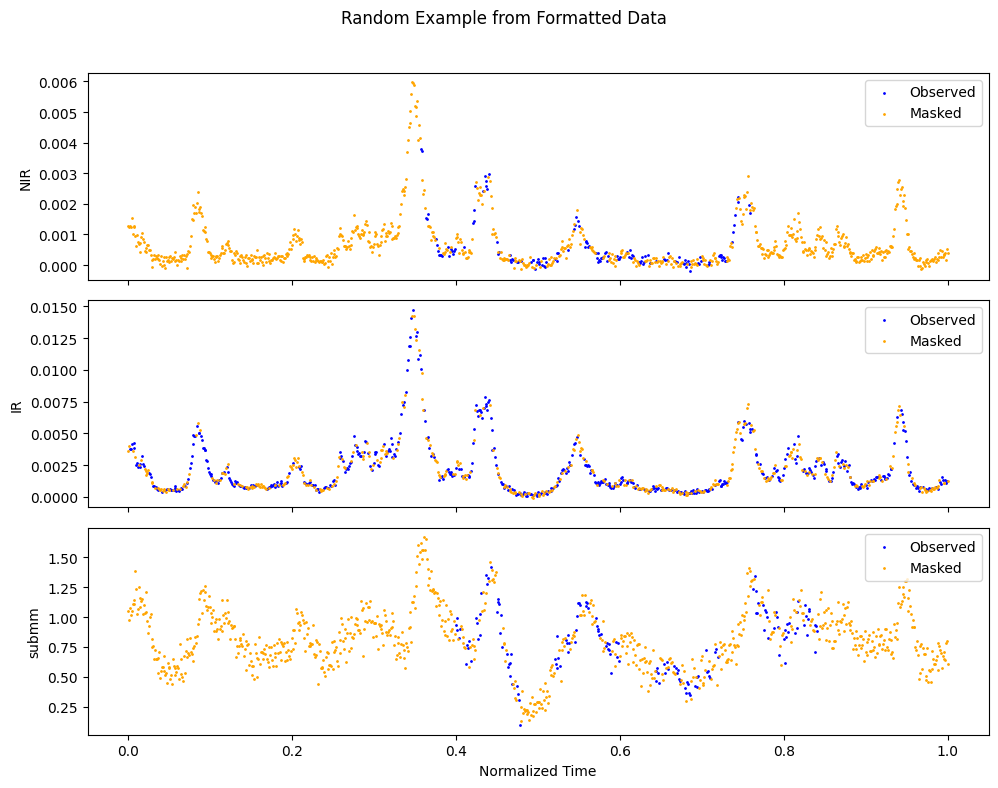

In [4]:
filename = 'noxray.npz'
keys = ['NIR', 'IR', 'submm']

simdata = simData(all_data)

simdata.mask_data(noise=0.2)

simdata.create_tripletformer_data(filename, keys=keys)

# Usage
simdata.plot_random_example(filename, keys=keys)

# Format data for training - X-ray only

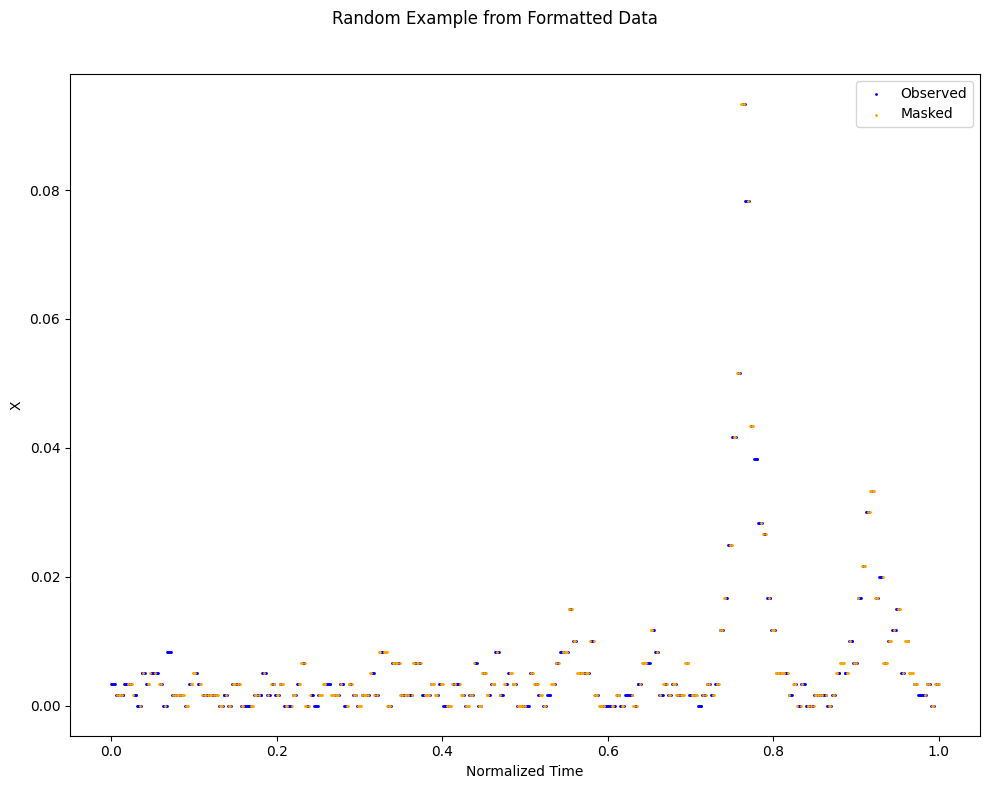

In [5]:
filename = 'xray.npz'
keys = ['X']

simdata = simData(all_data)

simdata.mask_data(noise=0.2)

simdata.create_tripletformer_data(filename, keys=keys)

# Usage
simdata.plot_random_example(filename, keys=keys)

# Format data for training - All data no masks

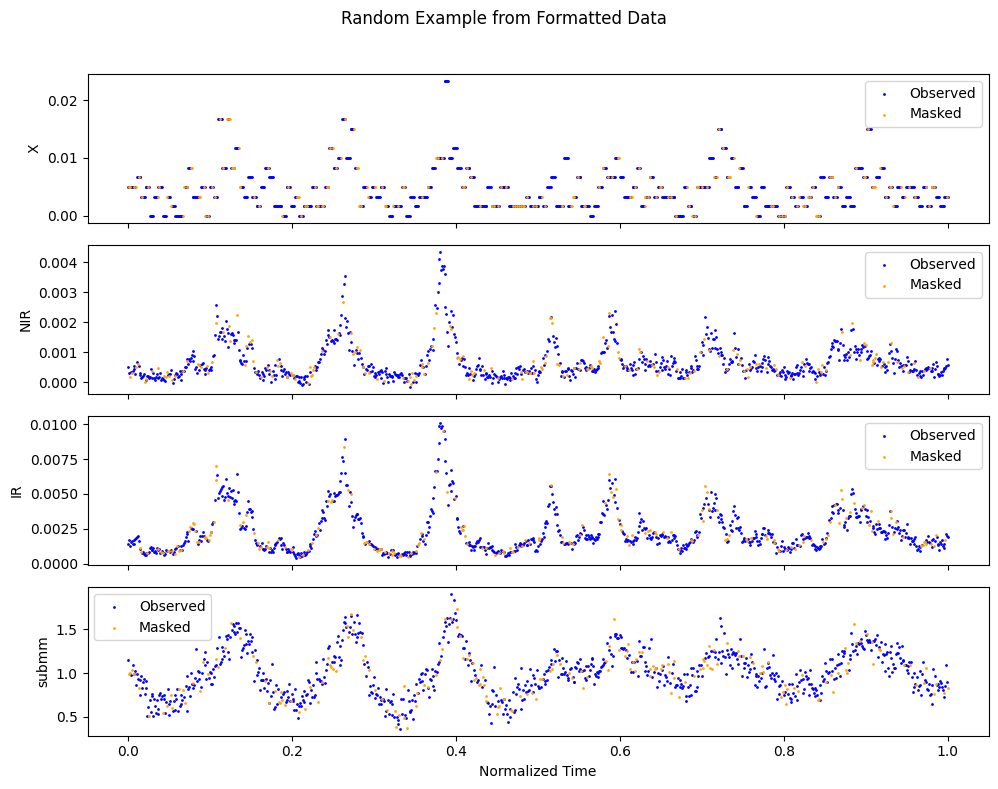

In [6]:
filename = 'sgra_no_mask.npz'
keys = ['X', 'NIR', 'IR', 'submm']

simdata = simData(all_data)

simdata.mask_data(mask=False, noise=0.2)

simdata.create_tripletformer_data(filename, keys=keys)

# Usage
simdata.plot_random_example(filename, keys=keys)

# Format data for training - All data no X-ray no masks

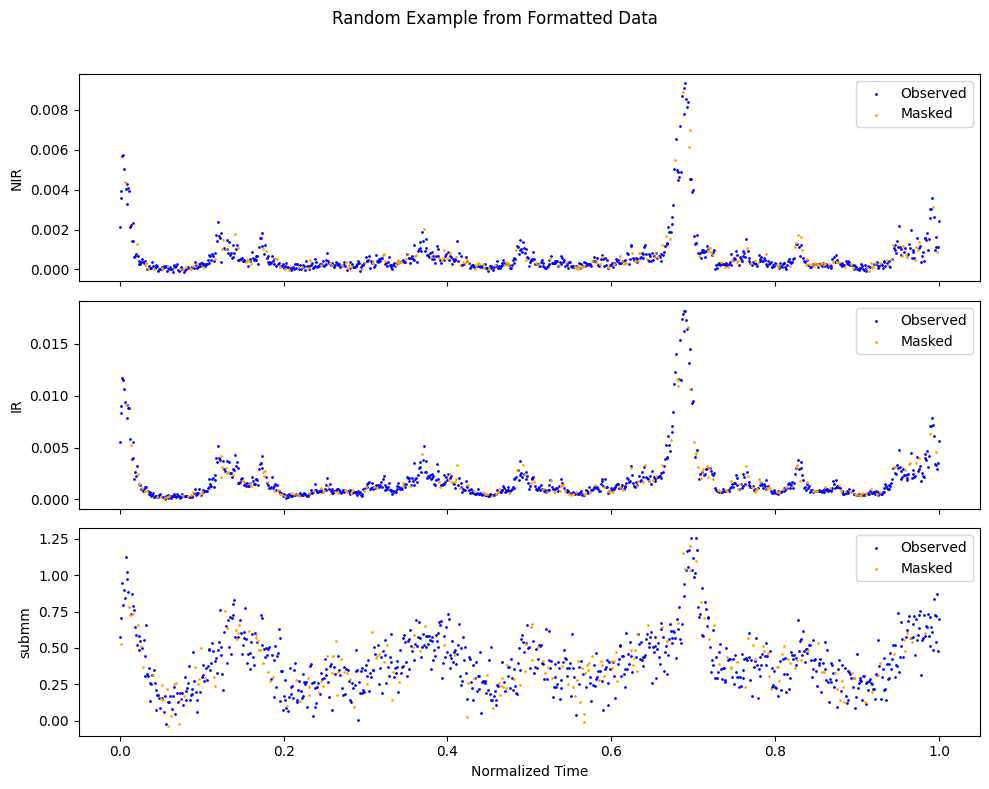

In [7]:
filename = 'noxray_no_mask.npz'
keys = ['NIR', 'IR', 'submm']

simdata = simData(all_data)

simdata.mask_data(mask=False, noise=0.2)

simdata.create_tripletformer_data(filename, keys=keys)

# Usage
simdata.plot_random_example(filename, keys=keys)